# 심화 발전 방향
- 추가 피처 (요일, 월, 과거 판매량) 생성
- XGBoost 모델에 TimeSeriesSplit 기반의 하이퍼파라미터 튜닝 적용

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# 1. 데이터 수집 & 통합

In [13]:
# (1) 날씨 데이터 다운로드 및 전처리
weather_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
weather_df = pd.read_csv(weather_url, parse_dates=['Date'])
weather_df.rename(columns={'Date':'date', 'Temp':'temp'}, inplace=True)

In [14]:
# (2) 합성 판매 데이터 생성
sales_df = pd.DataFrame({'date': weather_df['date']})
np.random.seed(42)
# 프로모션 여부: 0 (80%) 또는 1 (20%)
sales_df['promotion_flag'] = np.random.choice([0, 1], size=len(sales_df), p=[0.8, 0.2])
# 판매량 생성: 기본값 50, 기온의 영향 5배, 프로모션 시 추가 20, + 잡음
sales_df['sales'] = 50 + 5*weather_df['temp'] + 20 * sales_df['promotion_flag'] + np.random.normal(0, 5, len(sales_df))
# 강수량: 0~10 사이의 균등분포 난수
sales_df['rainfall'] = np.random.uniform(0, 10, len(sales_df))

In [15]:
# (3) 데이터 병합 (날짜 기준)
merged_df = pd.merge(sales_df, weather_df[['date', 'temp']], on='date', how='left')

In [16]:
merged_df

,date,promotion_flag,sales,rainfall,temp
0,1981-01-01,0,150.868761,7.086767,20.7
1,1981-01-02,1,166.441689,2.148546,17.9
2,1981-01-03,0,142.074891,0.403302,18.8
3,1981-01-04,0,124.914945,2.011365,14.6
4,1981-01-05,0,129.706286,1.786289,15.8
...,...,...,...,...,...
3645,1990-12-27,0,122.300212,2.724464,14.0
3646,1990-12-28,0,125.702206,5.491557,13.6
3647,1990-12-29,0,123.776749,7.218532,13.5
3648,1990-12-30,0,125.071625,9.933728,15.7


# 2. 심화된 피처 엔지니어링

In [17]:
# 날짜 관련 피처: 요일과 월 추가
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek  # 월:0 ~ 일:6
merged_df['month'] = merged_df['date'].dt.month

In [18]:
# 과거 판매량(lag feature): 전일 판매량
merged_df['lag_sales'] = merged_df['sales'].shift(1)
merged_df.dropna(inplace=True)  # 첫 행 제거 (lag feature 결측치)

In [19]:
# 범주형 변수: 요일, 월 -> 더미 변수 생성 (첫번째 카테고리는 기준으로)
merged_df = pd.get_dummies(merged_df, columns=['day_of_week', 'month'], drop_first=True)

In [21]:
# 날짜순 정렬
merged_df.sort_values(by='date', inplace=True)

# 3. 모델링: XGBoost & 하이퍼파라미터 튜닝

In [23]:
# Feature 및 타깃 설정 (날짜와 판매량 제외)
feature_cols = [col for col in merged_df.columns if col not in ['date', 'sales']]
X = merged_df[feature_cols]
y = merged_df['sales']

In [24]:
# 시계열 특성을 고려한 train/test split (80% train, 20% test)
split_index = int(0.8 * len(merged_df))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [27]:
# TimeSeriesSplit을 사용한 GridSearchCV 설정
tscv = TimeSeriesSplit(n_splits=5)
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

param_gird = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb_model, param_gird, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("최적 하이퍼파라미터:", grid_search.best_params_)

최적 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [28]:
# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 4. 평가 및 시각화

In [29]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("\n테스트 세트 평가 결과:")
print("RMSE:", rmse)
print("R^2:", r2)


테스트 세트 평가 결과:
RMSE: 5.174818739173832
R^2: 0.9452297503999929


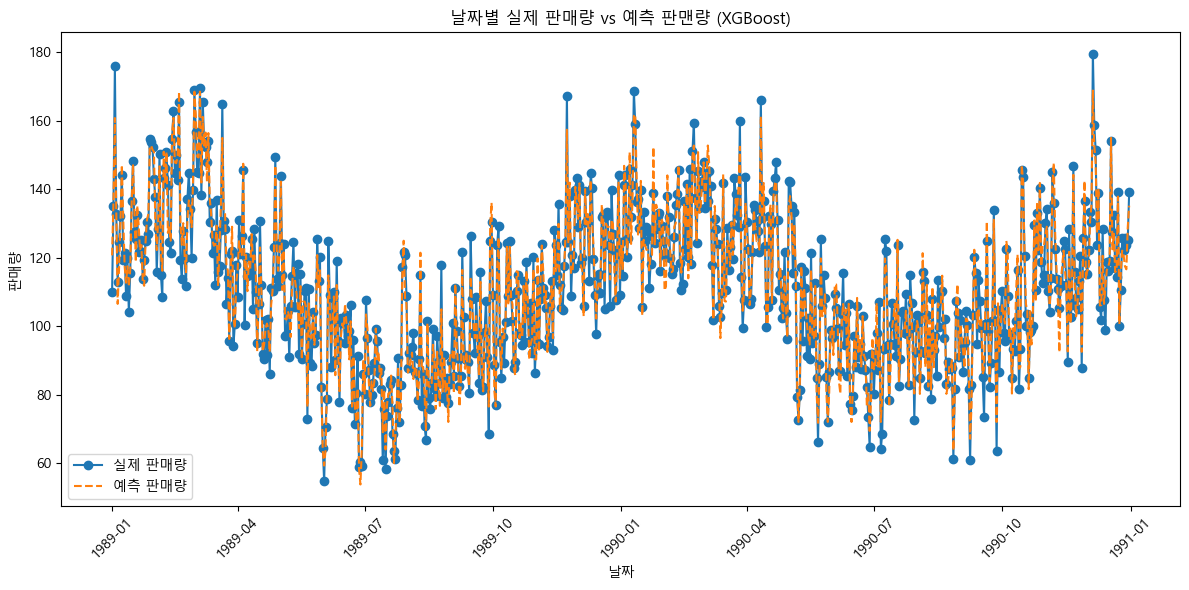

In [31]:
# 날짜별 실제 판매량 vs 예측 판매량 라인 차트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

dates_test = merged_df['date'].iloc[split_index:]
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='실제 판매량', marker='o')
plt.plot(dates_test, y_pred, label="예측 판매량", linestyle='--')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.title("날짜별 실제 판매량 vs 예측 판맨량 (XGBoost)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

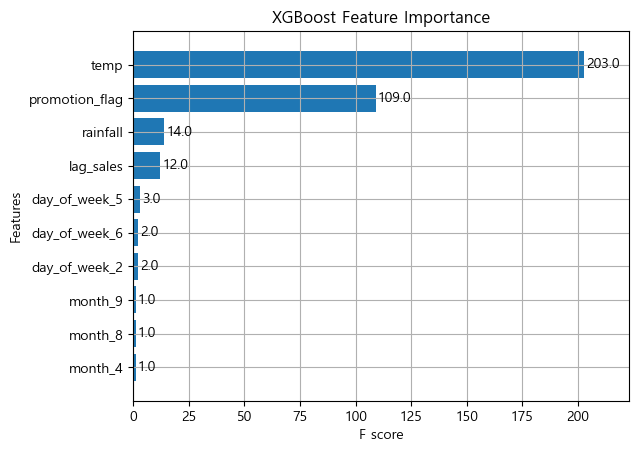

In [32]:
# XGBoost 피처 중요도 시각화
xgb.plot_importance(best_model, max_num_features=10, height=0.8)
plt.title('XGBoost Feature Importance')
plt.show()

- **결과 해석:**
    - **모델 성능:**
        - XGBoost 모델을 TimeSeriesSplit과 GridSearchCV로 하이퍼파라미터 튜닝한 결과, RMSE 약 5.17, R² 약 0.945로 데이터의 변동성을 매우 잘 설명함을 보여줍니다.
        - 이전 단순 모델(기온과 판매량의 상관관계 기반) 대비 RMSE와 R²에서 소폭 개선된 성능을 확인할 수 있습니다.
    - **피처 중요도:**
        - **기온(temp):** 가장 큰 영향력을 가지며, 판매량 예측에 있어 핵심 변수임을 확인할 수 있습니다.
        - **프로모션(promotion_flag)와 강수량(rainfall):** 두 번째로 중요한 피처로, 기온과 함께 판매에 영향을 미칩니다.
        - **시계열 및 기타 피처:** lag feature 및 날짜 관련 더미 변수들이 추가적인 정보를 제공하지만 상대적으로 영향력은 낮은 것으로 나타났습니다.